# Maximizing Regular Season Value Based on ADP 
## Participant: Alex Bohl
#### Twitter: @alexbohl122
#### LinkedIn: https://www.linkedin.com/in/alexbohl/

## Introduction

After reading the bestball manifesto, shoutout Mike Leone, a common strategy I used in drafting was trying to maximize ADP value. If I could get a player at a major discount according to ADP, I was often times smashing the draft button. As a community, best ball drafters are fantasy football savvy so drafting based on ADP can provide value. However, what I wanted to explore is can we use ADP to model the expected value of a player and use that to make even smarter draft decisions? My submission will explore how we can use predicted player value based on ADP and position, determine if using predicted player value can impact regular season advance rates, and the development of a tool that can assist in draft selections based on maximizing predicted player value.

In [1]:
# Import in needed libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import glob
from fuzzywuzzy import fuzz, process
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

## Data Prep

### Gather Player Performance Data

In [2]:
# Import weekly stats from nfl_data_py
week_stats = nfl.import_weekly_data([2022], columns = ['player_id', 'player_name', 'player_display_name',
       'position_group', 'week','completions', 'attempts', 'passing_yards',
       'passing_tds', 'interceptions', 'sack_fumbles_lost', 'passing_2pt_conversions','rushing_yards',
       'rushing_tds','rushing_fumbles_lost','rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles_lost','receiving_2pt_conversions','special_teams_tds',
       'fantasy_points', 'fantasy_points_ppr'], downcast=True)

# Filter dataframe to only be draftable positions on Underdog and regular season weeks (1-14) and create fantasy points column
week_stats_rs = (week_stats
                 .loc[(week_stats['position_group']
                 .isin(['QB','RB','WR','TE'])) & (week_stats['week'] <= 14)]
                 .copy()
                 .assign(fantasy_points_hppr = lambda x: x['fantasy_points'] + (.5 * x['receptions']))
                )

# Calculate each players positional rank for each week
week_stats_rs['weekly_rank'] = week_stats_rs.groupby(['week','position_group'])['fantasy_points_hppr'].rank(ascending = False,
                                                                                                           method = 'dense')

# Function to be used to indicate the quality of a performance
def create_performance_indicator(x, performance):
    '''
    x = dataframe row
    x = quality of performance, 'starter', 'great', 'elite'
    
    - Starter performances are performances that would have earned the player a starting spot.
    - Great performances are performances where an athlete ranked in the top 50% of startable performances. 
    - Elite performances are performance where an athlete ranked in top 16.67% of startable performances.
    '''
    starting = {'WR':36,
                'RB':24,
                'QB':12,
                'TE':12}
    
    if performance == 'starter':
        return x['weekly_rank'] <= starting[x['position_group']]
    if performance == 'great':
        return x['weekly_rank'] <= (starting[x['position_group']] / 2)
    if performance == 'elite':
        return x['weekly_rank'] <= (starting[x['position_group']] / 6)
    else:
        raise ValueError('Not a valid performance type!')
        
# Add performance indicator's to player performances        
week_stats_rs['starter_performance'] = week_stats_rs.apply(lambda x: create_performance_indicator(x, 'starter'), 
                                                           axis = 1)
week_stats_rs['great_performance'] = week_stats_rs.apply(lambda x: create_performance_indicator(x, 'great'), 
                                                           axis = 1)
week_stats_rs['elite_performance'] = week_stats_rs.apply(lambda x: create_performance_indicator(x, 'elite'),                                                           axis = 1)

Downcasting floats.


### Calculate Player Regular Season Value

Player value is calculated using better in best ball points or points above replacement (PAR), shoutout Hayden Winks, and a multiplier from the number of "great" games an athlete had. The reason I added the multiplier to a player's value is becuase there is value to having a player that can consistently have "great" games.

In [3]:
# Baseline points for point above replacement.
players_adj_value = (pd.merge(week_stats_rs, (week_stats_rs.loc[((week_stats_rs['position_group'] == 'QB') & (week_stats_rs['weekly_rank'] == 12)) 
                  | ((week_stats_rs['position_group'] == 'RB') & (week_stats_rs['weekly_rank'] == 24)) 
                  | ((week_stats_rs['position_group'] == 'WR') & (week_stats_rs['weekly_rank'] == 36)) 
                  | ((week_stats_rs['position_group'] == 'TE') & (week_stats_rs['weekly_rank'] == 12))][['week','position_group','fantasy_points_hppr']]
                                        .drop_duplicates(subset = ['week','position_group'])
                                        .sort_values(by = 'week')
                                        .reset_index(drop = True)
                                        .rename(columns = {'fantasy_points_hppr':'replacement_pts'})
                                       )
                        , on = ['week','position_group'])
               .assign(par = lambda x: np.where(x['fantasy_points_hppr'] > x['replacement_pts'], x['fantasy_points_hppr'] - x['replacement_pts'],0))
               .groupby(by = ['player_id', 'player_display_name']).agg(par = ('par',np.sum),
                                                                      num_great = ('great_performance', np.sum)
                                                                      )
               .reset_index()
               .assign(adjusted_value = lambda x: x['par'] * (1 + x['num_great'] * .1))
               .sort_values(by = 'adjusted_value', ascending = False)
              )

### Best Ball Data Prep

In [4]:
# Function that gathers all regular season and post season data. Cleaning is performed to gather post season details. 
def gather_bestball_files():
    # regular season data gathering
    path = '**/2022/regular_season/*/*.csv'
    rs_files = glob.glob(path,recursive = True)

    bb_rs = pd.DataFrame()
    for f in rs_files:
        bb_rs = pd.concat([bb_rs, pd.read_csv(f)])
    
    # Post season data gathering
    path = '**/2022/post_season/*/*.csv'
    ps_files = glob.glob(path, recursive = True)

    bb_ps = pd.DataFrame()
    for f in ps_files:
        bb_ps = pd.concat([bb_ps, pd.read_csv(f)])
        
    # gather post season details for teams
    bb_ps['quarterfinals'] = bb_ps['tournament_round_number'].apply(lambda x: 1 if x == 2 else 0)
    bb_ps['semifinals'] = bb_ps['tournament_round_number'].apply(lambda x: 1 if x == 3 else 0)
    bb_ps['finals'] = bb_ps['tournament_round_number'].apply(lambda x: 1 if x == 4 else 0)
    # Create new dataframe that contains details on the post season finish of each team
    bb_ps_details = (bb_ps
                     .groupby(by = 'tournament_entry_id')
                     .agg({'playoff_team': 'max','quarterfinals' : 'max','semifinals':'max','finals':'max'})
                     .reset_index()
                    )
    
    # Create a combined dataframe of post season and regular season teams
    bb_rs_ps = (bb_rs
                .drop(columns = ['playoff_team'])
                .merge(bb_ps_details, how = 'left' ,on = 'tournament_entry_id')
                .fillna(0)
                .assign(draft_time = lambda x: pd.to_datetime(x['draft_time']))
               )
    
    return bb_rs_ps

bb_rs_ps = gather_bestball_files()

### Fuzzy Matching NFL Data with Underdog Data

Performed fuzzy matching on the data gathered from NFL_data_py and Underdog best ball data to ensure that the players in the best ball data were receiving their correct adjusted value. 

In [5]:
# Create a lookup tables for performance data and best ball data

performance_lookup = (week_stats_rs[['player_id','player_display_name','position_group']]
                      .drop_duplicates()
                      .assign(lookup = lambda x: x['player_display_name'] + x['position_group'])
                      .drop(columns = ['player_display_name','position_group'])
                     )

bestball_lookup = (bb_rs_ps[['player_name','position_name']]
                   .drop_duplicates()
                   .assign(lookup = lambda x: x['player_name'] + x['position_name'])
                   .drop(columns = ['player_name','position_name'])
                  )

# Creating a function to return the best match, above a score of 90, between a passed in value and possible choices 
def get_best_match(value, choices):
    try:
        best_match, score = process.extractOne(value, choices, score_cutoff = 90)
        return best_match
    except:
        return np.NaN
    
# Finding the best match for each drafted Underdog player in the NFL data
bestball_lookup['performance match'] = bestball_lookup['lookup'].apply(lambda x: get_best_match(x, list(performance_lookup['lookup'])))

# Creating a new dataframe combining the two lookup tables
player_lookup = (bestball_lookup
                 .merge(performance_lookup, how = 'left', left_on = 'performance match', right_on = 'lookup')
                 .drop(columns = ['lookup_y','performance match'])
                 .rename(columns = {'lookup_x':'bb_lookup'})
                )

In [6]:
# Check if multiple Underdog drafted players matched to one athlete in the weekly stats data. These will need to addresed.
(player_lookup
 .groupby(by = 'player_id')['bb_lookup'].count()
 .reset_index()
 .sort_values(by = 'bb_lookup', ascending = False)
 .query('bb_lookup > 1')
)

,player_id,bb_lookup
124,00-0033536,2


In [7]:
# Find bestball drafted athletes that have same player_id
display(player_lookup.loc[player_lookup['player_id'] == '00-0033536'])
# Double check to ensure that Malik Williams was not part of the weekly stats data
if len(week_stats_rs.loc[week_stats_rs['player_display_name'] == 'Malik Williams']) == 0:
    print('Good to go!')
else:
    print('Malik Williams played a snap and needs a player_id!')
# Change Malik Willaim's player id to a null value
player_lookup.loc[(player_lookup['player_id'] == '00-0033536') & (player_lookup['bb_lookup'] == 'Malik WilliamsWR'),'player_id'] = np.NaN

,bb_lookup,player_id
141,Mike WilliamsWR,00-0033536
658,Malik WilliamsWR,00-0033536


Good to go!


In [8]:
# Creating final best ball dataframe by merging bb_rs_ps data with player lookup data
bb_data = (bb_rs_ps
           .assign(bb_lookup = lambda x: x['player_name'] + x['position_name'])
           .merge(player_lookup, how = 'left', on = 'bb_lookup')
          )

## Explore Traditional ADP Value

In this section, we explore the impact of ADP value on regular season advance rate. We have prior knowledge that ADP value is important to regular season advance rate, but is there anything else we can learn?

In [9]:
print(f'Last draft of BBM3 was on {bb_data.draft_time.max()}')

Last draft of BBM3 was on 2022-09-08 02:59:36.993700


In [10]:
# Get final adp of players. Final ADP and number of drafts are determined by the drafts one month before BBM3 close.
bb_final_adp = (bb_data
                .loc[(bb_data['draft_time'] >= '2022-08-08') & (bb_data['draft_time'] < '2022-09-09')]
                .groupby(['player_name','position_name','player_id'], dropna = False)['overall_pick_number'].mean()
                .reset_index()
                .merge(bb_data
                       .loc[(bb_data['draft_time'] >= '2022-08-08') & (bb_data['draft_time'] < '2022-09-09')]
                       .groupby(['player_name','position_name','player_id'], dropna = False)['draft_entry_id'].count()
                       .reset_index()
                       .drop(columns = ['player_id']),
                      on = ['player_name','position_name'])
                .rename(columns = {'overall_pick_number':'final_adp','draft_entry_id':'num_drafts'})
               )

# Merging the final adp to bb_data and creating adp value column using final adp of player. 
# If a player was not drafted at all in the last month then their final adp is latest possible pick (216)
bb_data = (bb_data
           .merge(bb_final_adp.drop(columns = ['player_id']), on = ['player_name', 'position_name'], how = 'left')
           .assign(final_adp = lambda x: x['final_adp'].fillna(bb_data['overall_pick_number'].max()),
                   num_drafts = lambda x: x['num_drafts'].fillna(0),
                   adp_value_final = lambda x: x['overall_pick_number'] - x['final_adp'],
                   position_name = lambda x: x['position_name'].replace('FB', 'RB'))
          )

In [11]:
# Create two lists, one for the labels of the buckets and the second for the percentiles of each bucket
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Find each team's adp value based on the final adp of players
team_adp_value = (bb_data
                  .groupby(by = 'tournament_entry_id').agg(final_adp_value = ('adp_value_final', np.sum),
                                                          playoff_team = ('playoff_team','max'))
                  .reset_index()
                  .assign(final_percentile = lambda x: x['final_adp_value'].rank(pct = True),
                         final_bucket = lambda x: pd.cut(x['final_percentile'], 
                                                         bins = bins, 
                                                         labels = labels))
                 )

,final_bucket,playoff_teams,min_adp_value,max_adp_value,num_teams,advance_rate,over_expected,percent_over_expected
0,1,4353.0,-1105.407124,-100.684249,45120,9.65,0,-7.02
1,2,5594.0,-100.683994,-62.064063,45120,12.40,0,-4.27
2,3,6426.0,-62.063743,-36.909136,45120,14.24,0,-2.43
3,4,6592.0,-36.909115,-17.387616,45120,14.61,0,-2.06
4,5,7235.0,-17.387388,-0.159204,45120,16.04,0,-0.63
5,6,7708.0,-0.158783,16.478988,45120,17.08,1,0.41
6,7,8165.0,16.480063,33.683088,45120,18.10,1,1.43
7,8,8845.0,33.683092,54.376778,45120,19.60,1,2.93
8,9,9539.0,54.377531,84.959441,45120,21.14,1,4.47
9,10,10743.0,84.959648,478.744661,45120,23.81,1,7.14


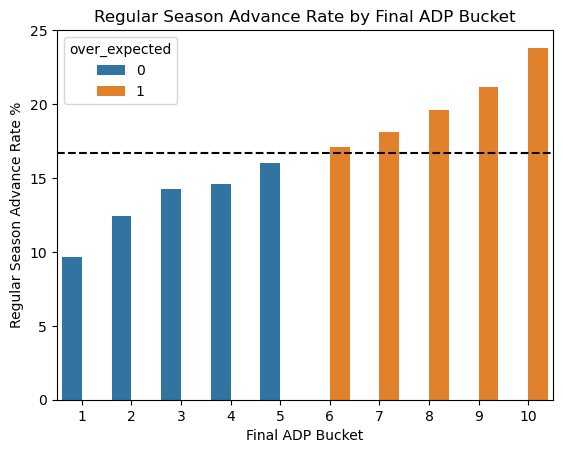

In [12]:
# Looking at advance rate by final bucket 
display((team_adp_value.
groupby(by = 'final_bucket').agg(playoff_teams = ('playoff_team',np.sum),
                                 min_adp_value = ('final_adp_value','min'),
                                 max_adp_value = ('final_adp_value','max'),
                                num_teams = ('tournament_entry_id','nunique'))
.reset_index()
.assign(advance_rate = lambda x: round((x['playoff_teams'] / x['num_teams']) * 100, 2),
       over_expected = lambda x: x['advance_rate'].apply(lambda y: 1 if y > ((2/12)*100) else 0),
       percent_over_expected = lambda x: round((x['advance_rate'] - (2/12)*100), 2))
        )
       )

sns.barplot(data = (team_adp_value.
                    groupby(by = 'final_bucket').agg(playoff_teams = ('playoff_team',np.sum),
                                                     min_adp_value = ('final_adp_value','min'),
                                                     max_adp_value = ('final_adp_value','max'),
                                                     num_teams = ('tournament_entry_id','nunique'))
                    .reset_index()
                    .assign(advance_rate = lambda x: round((x['playoff_teams'] / x['num_teams']) * 100,2),
                            over_expected = lambda x: x['advance_rate'].apply(lambda y: 1 if y > ((2/12)*100) else 0),
                            percent_over_expected = lambda x: round((x['advance_rate'] - (2/12)) * 100, 2))
                   ),
           x = 'final_bucket',
           y = 'advance_rate',
           hue = 'over_expected').set(title = 'Regular Season Advance Rate by Final ADP Bucket',
                                      ylabel = 'Regular Season Advance Rate %',
                                      xlabel = 'Final ADP Bucket')


plt.axhline((2/12)*100,
            color = 'black',
            linestyle = '--')

plt.show()

Maximizing ADP value is a great way to boost your chances of advancing past the regular season. Teams in buckets 6-10, 50th to 100th percentile all have a regular season advance rate over expectation. The higher the bucket, the more ADP value a team has, and the better the regular season advance rate. 

In [13]:
# Calculate positional ADP value for each team
team_adp_value_positions = (bb_data
                            .groupby(by = ['tournament_entry_id', 'position_name']).agg(final_adp_value = ('adp_value_final', np.sum),
                                                                                        playoff_team = ('playoff_team','max'))
                            .reset_index()
                           )
# Pivot the positional ADP dataframe on position to rank positional value into buckets
team_adp_value_positions_pivot = (team_adp_value_positions
                                 .pivot(index = ['tournament_entry_id','playoff_team'],
                                        columns = 'position_name',
                                        values = 'final_adp_value')
                                  .reset_index()
                                  .assign(qb_percentile = lambda x: x['QB'].rank(pct = True),
                                         rb_percentile = lambda x: x['RB'].rank(pct = True),
                                         wr_percentile = lambda x: x['WR'].rank(pct = True),
                                         te_percentile = lambda x: x['TE'].rank(pct = True),
                                         qb_bucket = lambda x: pd.cut(x['qb_percentile'], 
                                                                      bins = bins, 
                                                                      labels = labels),
                                         rb_bucket = lambda x: pd.cut(x['rb_percentile'], 
                                                                      bins = bins, 
                                                                      labels = labels),
                                         wr_bucket = lambda x: pd.cut(x['wr_percentile'], 
                                                                      bins = bins, 
                                                                      labels = labels),
                                         te_bucket = lambda x: pd.cut(x['te_percentile'], 
                                                                      bins = bins, 
                                                                      labels = labels))
                                 )

In [14]:
# Explore advance rate by positional ADP value
for position in ['qb','rb','wr','te']:
    print(f'Advance rate by {position} ADP value bucket:')
    
    display(team_adp_value_positions_pivot
            .groupby(by = f'{position}_bucket').agg(playoff_teams = ('playoff_team', np.sum),
                                                    num_teams = ('tournament_entry_id','nunique'),
                                                    min_adp_value = (f'{str.upper(position)}','min'),
                                                    max_adp_value = (f'{str.upper(position)}','max'),)
            .reset_index()
            .assign(advance_rate = lambda x: round((x['playoff_teams'] / x['num_teams']) * 100,2),
                   over_expected = lambda x: x['advance_rate'].apply(lambda y: 1 if y > ((2/12)*100) else 0),
                   percent_over_expected = lambda x: round(x['advance_rate'] - ((2/12)*100), 2))
           )

Advance rate by qb ADP value bucket:


,qb_bucket,playoff_teams,num_teams,min_adp_value,max_adp_value,advance_rate,over_expected,percent_over_expected
0,1,5530.0,45120,-416.587351,-28.262448,12.26,0,-4.41
1,2,6400.0,45119,-28.261039,-16.601154,14.18,0,-2.49
2,3,7084.0,45121,-16.600318,-9.782775,15.70,0,-0.97
3,4,7421.0,45176,-9.782728,-5.162165,16.43,0,-0.24
4,5,7326.0,44892,-5.161804,-0.752549,16.32,0,-0.35
5,6,8138.0,45292,-0.751695,3.474466,17.97,1,1.30
6,7,8421.0,45120,3.474826,7.800801,18.66,1,1.99
7,8,8352.0,45147,7.801386,13.118662,18.50,1,1.83
8,9,8211.0,45083,13.118735,20.952814,18.21,1,1.54
9,10,8317.0,45130,20.953345,162.737168,18.43,1,1.76


Advance rate by rb ADP value bucket:


,rb_bucket,playoff_teams,num_teams,min_adp_value,max_adp_value,advance_rate,over_expected,percent_over_expected
0,1,5452.0,45120,-595.538585,-40.863299,12.08,0,-4.59
1,2,6337.0,45120,-40.862945,-23.281557,14.04,0,-2.63
2,3,6766.0,45120,-23.281468,-12.308680,15.00,0,-1.67
3,4,7030.0,45120,-12.308598,-3.779943,15.58,0,-1.09
4,5,7263.0,45120,-3.779830,3.816889,16.10,0,-0.57
5,6,7770.0,45120,3.817003,11.335943,17.22,1,0.55
6,7,7894.0,45120,11.336113,19.786859,17.50,1,0.83
7,8,8214.0,45120,19.786884,30.661546,18.20,1,1.53
8,9,8773.0,45120,30.661920,48.212023,19.44,1,2.77
9,10,9701.0,45120,48.212110,300.678170,21.50,1,4.83


Advance rate by wr ADP value bucket:


,wr_bucket,playoff_teams,num_teams,min_adp_value,max_adp_value,advance_rate,over_expected,percent_over_expected
0,1,4976.0,45120,-439.809958,-59.567971,11.03,0,-5.64
1,2,6381.0,45120,-59.567849,-35.536663,14.14,0,-2.53
2,3,6815.0,45120,-35.535857,-21.134043,15.10,0,-1.57
3,4,7135.0,45120,-21.133927,-10.394899,15.81,0,-0.86
4,5,7479.0,45120,-10.394679,-1.010637,16.58,0,-0.09
5,6,7912.0,45120,-1.010504,8.104231,17.54,1,0.87
6,7,8048.0,45120,8.104358,18.008657,17.84,1,1.17
7,8,8474.0,45120,18.008716,30.381439,18.78,1,2.11
8,9,8767.0,45120,30.381866,50.941429,19.43,1,2.76
9,10,9213.0,45120,50.942522,370.210960,20.42,1,3.75


Advance rate by te ADP value bucket:


,te_bucket,playoff_teams,num_teams,min_adp_value,max_adp_value,advance_rate,over_expected,percent_over_expected
0,1,5790.0,45121,-399.488469,-28.415241,12.83,0,-3.84
1,2,6667.0,45119,-28.414458,-16.792736,14.78,0,-1.89
2,3,6890.0,45119,-16.791559,-10.144307,15.27,0,-1.40
3,4,7327.0,45121,-10.144267,-5.220469,16.24,0,-0.43
4,5,7498.0,45120,-5.220354,-0.877547,16.62,0,-0.05
5,6,7836.0,45120,-0.877330,3.068997,17.37,1,0.70
6,7,7787.0,45120,3.069669,7.511385,17.26,1,0.59
7,8,7919.0,45120,7.511853,12.602367,17.55,1,0.88
8,9,8473.0,45120,12.602386,20.424810,18.78,1,2.11
9,10,9013.0,45120,20.424831,138.921263,19.98,1,3.31


Similar to total ADP value, teams in the top 50% of positional ADP value have above expectation regular season advance rates. This holds true for all positions. However, there is a positional difference in the impact of ADP value on regular season advance rate. For example, being in the 90th to 100th percentile for RB ADP value positively impacts your chances of making it to the playoffs more than being in the 90th to 100th percentile for WR ADP value.

### Should we consider position more when looking at ADP value? Can we use ADP to help predict "value" from a player?
#### I think so.

## Expected Value by ADP

In [15]:
# Merge final ADP from BBM3 with each player's adjusted value
bb_adj_value = (bb_final_adp
         .merge(players_adj_value.drop(columns = ['player_display_name','num_great']), how = 'left', on = 'player_id')
         .assign(par = lambda x: x['par'].fillna(0),
                 adjusted_value = lambda x: x['adjusted_value'].fillna(0),
                 position_name = lambda x: x['position_name'].replace('FB', 'RB'))
         )
               
# Merge complete BBM3 data with adjusted value data
bb_data = (bb_data
           .merge(bb_adj_value.drop(columns = ['player_id','final_adp','num_drafts']),
                 how = 'left',
                 on = ['player_name','position_name'])
          )

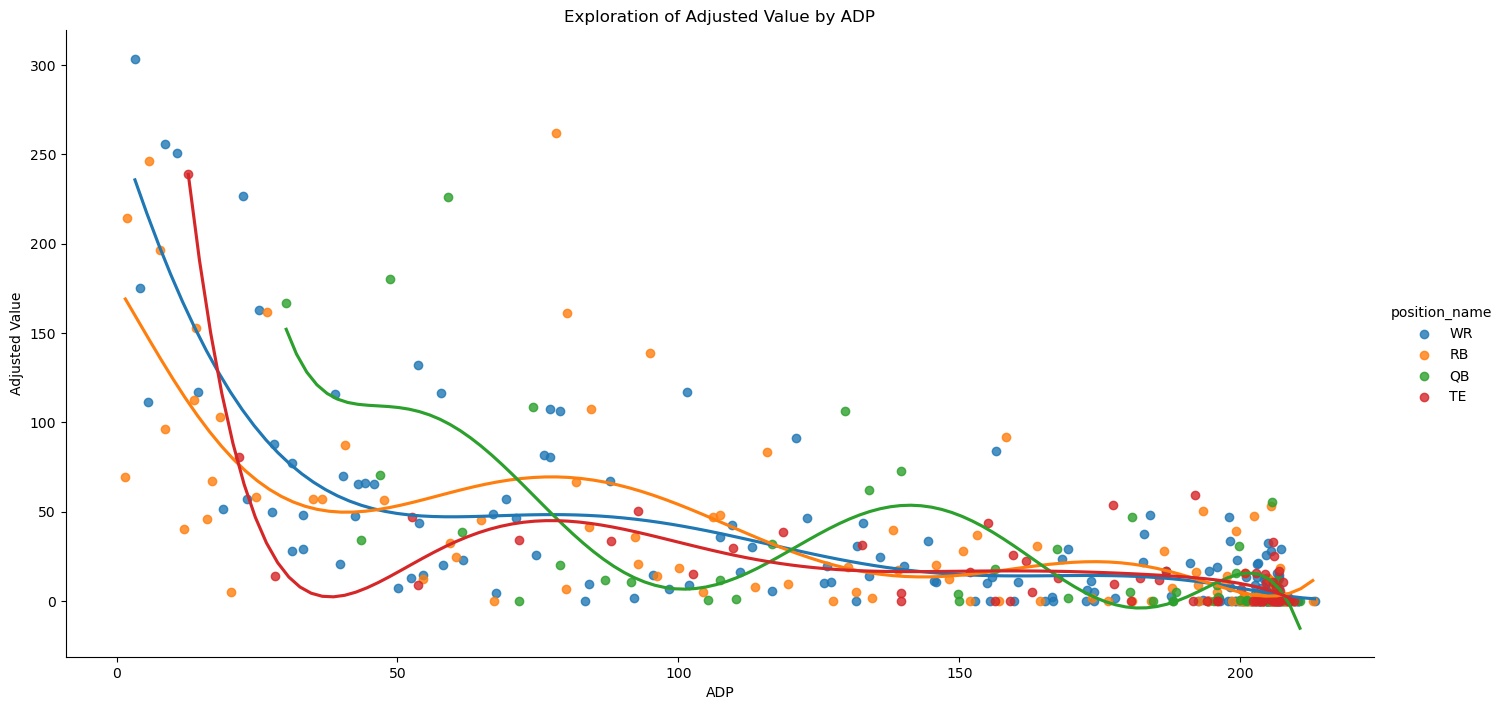

In [16]:
# Explore non-linear trends in ADP and adjusted value by position
sns.lmplot(x = 'final_adp',
           y = 'adjusted_value',
           data = bb_adj_value.loc[bb_adj_value['num_drafts'] >=5],
           hue = 'position_name',
           order = 7, 
           ci = None,
           height = 7,
           aspect = 2).set(title = 'Adjusted Value by Final ADP')

plt.ylabel('Adjusted Value')
plt.xlabel('ADP')
plt.title('Exploration of Adjusted Value by ADP')

plt.show()

Using BBM3 data we can see how ADP and the adjusted value of a player interact. The interaction between ADP and adjusted value is not linear. There are points where the estimated adjusted value can drastically decrease in a certain ADP range. There are points where the estimated adjusted value can incerase in a certain range compared to an early point. 

This plot was used for exmploration purposes. We used a polynomial order of 7, this does not result in the best fit for all positions.

#### Understanding the relationship between ADP and adjusted value for each position can help us make smarter draft decisions. We can identify player's with the greatest estimated adjusted value. We can identify selections that would result in the greatest adjusted ADP value, the difference in estimated adjusted value at a player's ADP versus the estimated adjusted value at current pick number.

## Model Development

For each position we will develop a polynomial regression model that will best predict the adjusted value of a player.

In [17]:
# Data set to be used in model development.
model_data = (bb_adj_value
              .loc[bb_adj_value['num_drafts'] >=5]
              .copy()
              .set_index('player_name')
             )


# Function to prepare data for model training for each position. Creates training and test sets.
def create_test_train(position):
    if position not in ['QB','RB','WR','TE']:
        print('Not a valid position! Must be QB, RB, WR, or TE.')
    else:
        # Use filtered dataset for model development. Players must have been drafted at least 5 times. 
        data = (model_data
                .loc[model_data['position_name'] == position]
                )
        # X and y variables for model training and testing
        X = data['final_adp']
        y = data['adjusted_value']

        # Create test and training sets. Set the seed to 4 for BBM4
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25, random_state= 4)

        return X_train, X_test, y_train, y_test

In [18]:
# Function to find the optimal number of degrees for the polynomial regression model. Can be used for each position.
def find_best_degree(position, max_degree, display_table = False, display_chart = False):
    X_train, X_test, y_train, y_test = create_test_train(position)

    poly_rmse_train = []
    poly_rmse_test = []

    for d in range(1,max_degree + 1):
        poly_convertor = PolynomialFeatures(degree = d, include_bias= False)
        poly_X_test = poly_convertor.fit_transform(X_test.values.reshape(-1,1))
        poly_X_train = poly_convertor.fit_transform(X_train.values.reshape(-1,1))

        poly_regression = LinearRegression()

        poly_regression.fit(poly_X_train, y_train)

        poly_rmse_test.append(mean_squared_error(y_test, poly_regression.predict(poly_X_test), squared = False))
        poly_rmse_train.append(mean_squared_error(y_train, poly_regression.predict(poly_X_train), squared = False))

    if display_chart:
        display(sns.lineplot(data = pd.DataFrame().assign(test = poly_rmse_test,
                                                  train = poly_rmse_train,
                                                 index = range(1,max_degree+1)).set_index('index'),
                    ).set(ylabel = 'RMSE',
                          xlabel = 'Polynomial Degrees',
                          title = f'{position} Polynomial Regression Test/Train RMSE')
               )

    if display_table:
        display(pd.DataFrame()
                .assign(test_RMSE = poly_rmse_test,
                        train_RMSE = poly_rmse_train,
                        degrees = range(1,max_degree + 1)).set_index('degrees')
                .sort_values('test_RMSE')
                .head(3)
               )
    return X_train, y_train

In [19]:
# Find best degree for the QB position
qb_X_train, qb_y_train = find_best_degree('QB', 20)

Using a 9-degree polynomial model, on average our adjusted value predictions for QBs are off by 23.4 points.

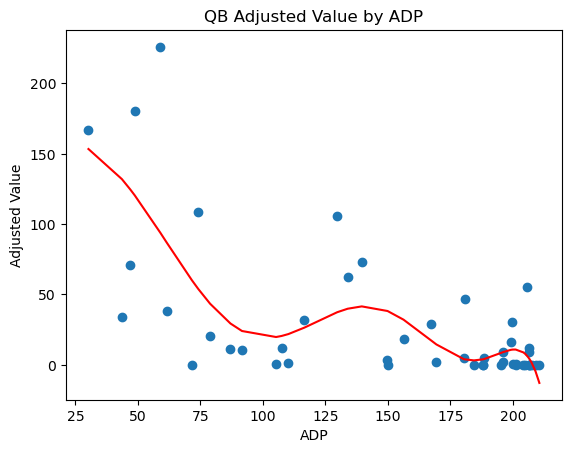

In [20]:
# Final QB polynomial regression model

qb_poly_convertor = PolynomialFeatures(degree = 9 , include_bias= False)
qb_poly_X_train = qb_poly_convertor.fit_transform(qb_X_train.values.reshape(-1,1))

qb_poly = LinearRegression()
qb_poly.fit(qb_poly_X_train, qb_y_train)

qb_x = model_data.loc[model_data['position_name'] == 'QB']['final_adp'].sort_values()
qb_pred = qb_poly.predict(qb_poly_convertor.fit_transform(qb_x.values.reshape(-1,1)))

plt.scatter(model_data.loc[model_data['position_name'] == 'QB']['final_adp'], model_data.loc[model_data['position_name'] == 'QB']['adjusted_value'])
plt.plot(qb_x, qb_pred, c = 'red')
plt.xlabel('ADP')
plt.ylabel('Adjusted Value')
plt.title('QB Adjusted Value by ADP')
plt.show()

#### Based on our QB model, we can see the value that the early QBs can bring. However, the expected adjusted value of a QB decreases quickly from pick 50 to around 110. The appearance of "QB Dead Zone" can be seen around picks 90 to 110. Starting at 110 to 150 we see a rise in expected adjusted value, there is potential for some QB value picks in this area.

In [21]:
# Find best degree for rb position
rb_X_train, rb_y_train = find_best_degree('RB', 20)

Using a 5-degree polynomial model, on average our adjusted value predictions for RBs are off by 43 points.

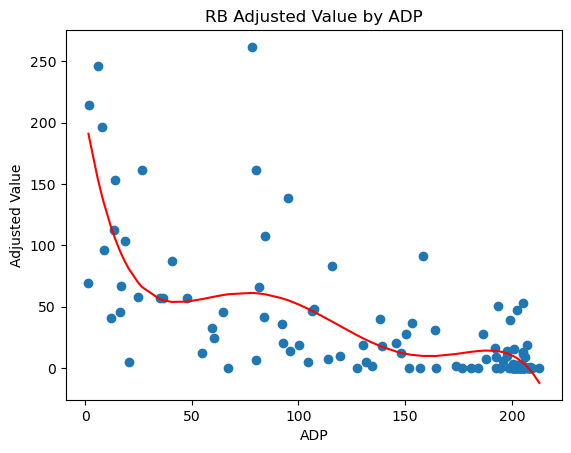

In [22]:
# Final RB polynomial regression model
rb_poly_convertor = PolynomialFeatures(degree = 5 , include_bias= False)
rb_poly_X_train = rb_poly_convertor.fit_transform(rb_X_train.values.reshape(-1,1))

rb_poly = LinearRegression()
rb_poly.fit(rb_poly_X_train, rb_y_train)

rb_x = model_data.loc[model_data['position_name'] == 'RB']['final_adp'].sort_values()
rb_pred = rb_poly.predict(rb_poly_convertor.fit_transform(rb_x.values.reshape(-1,1)))

plt.scatter(model_data.loc[model_data['position_name'] == 'RB']['final_adp'], model_data.loc[model_data['position_name'] == 'RB']['adjusted_value'])
plt.plot(rb_x, rb_pred, c = 'red')
plt.xlabel('ADP')
plt.ylabel('Adjusted Value')
plt.title('RB Adjusted Value by ADP')
plt.show()

#### Based on our RB model, we see expected adjusted value peaks in the early few picks and the expereiences a sharp decline in expected adjusted value until pick 40. Around pick 40 to 100 we see a plateau in expected adjusted value, with a small peak around 75. RB going around pick 75 until pick 100 could be good potential values. After pick 100 we see a steady decline in expected adjusted value until pick 150. After pick 150 we see another plateau until pick 200, RBs going in this pick range could be good late draft RB targets. 

In [23]:
# Find best degree for wr position
wr_X_train, wr_y_train = find_best_degree('WR', 20)

Using a 7-degree polynomial model, on average our adjusted value predictions for WRs are off by 27.5 points.

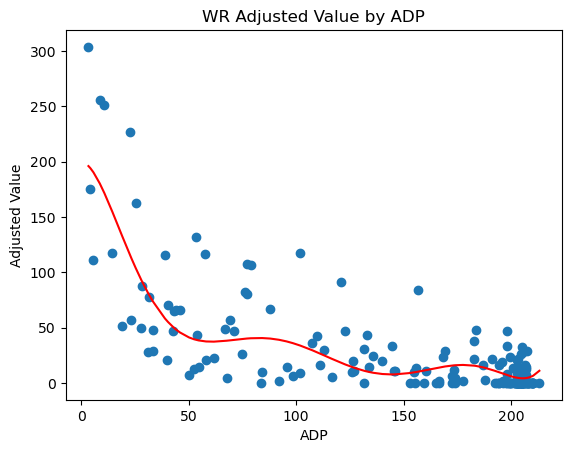

In [24]:
# Final WR polynomial regression model
wr_poly_convertor = PolynomialFeatures(degree = 7 , include_bias= False)
wr_poly_X_train = wr_poly_convertor.fit_transform(wr_X_train.values.reshape(-1,1))

wr_poly = LinearRegression()
wr_poly.fit(wr_poly_X_train, wr_y_train)

wr_x = model_data.loc[model_data['position_name'] == 'WR']['final_adp'].sort_values()
wr_pred = wr_poly.predict(wr_poly_convertor.fit_transform(wr_x.values.reshape(-1,1)))

plt.scatter(model_data.loc[model_data['position_name'] == 'WR']['final_adp'], model_data.loc[model_data['position_name'] == 'WR']['adjusted_value'])
plt.plot(wr_x, wr_pred, c = 'red')
plt.xlabel('ADP')
plt.ylabel('Adjusted Value')
plt.title('WR Adjusted Value by ADP')
plt.show()

#### Based on WR model, WRs display the highest expected adjusted value in the early picks (spoiler - the TEs do not beat out the WRs). This provides evidence that early picks spent on WRs will provide the greatest expected adjusted value. From picks 1 to 50, we see a sharp decline in expected adjusted value. From pick 50 to 90, we see a relatively consistent estimated adjusted value. With similar estimated adjusted value coming from WRs with an ADP of 90 as WRs with an ADP of 50, it might be wise to look at other positions around pick 50 and come back to WRs around pick 90, if you want a WR in this range. 

In [25]:
# Find best degree for TE position
te_X_train, te_y_train = find_best_degree('TE', 20)

Using a 2-degree polynomial model, on average our adjusted value predictions for TEs are off by 12.9 points.

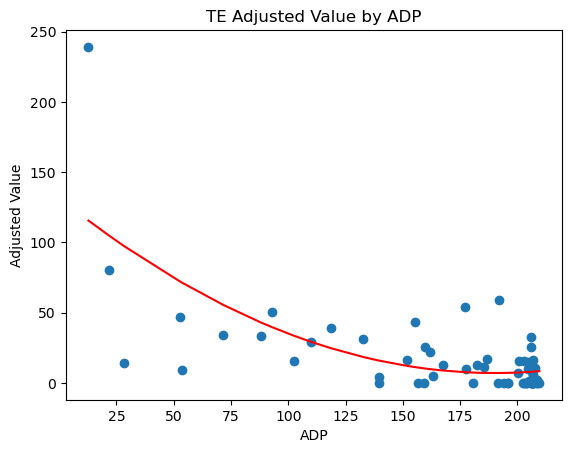

In [26]:
# Final TE polynomial regression model
te_poly_convertor = PolynomialFeatures(degree = 2, include_bias= False)
te_poly_X_train = te_poly_convertor.fit_transform(te_X_train.values.reshape(-1,1))

te_poly = LinearRegression()
te_poly.fit(te_poly_X_train, te_y_train)

te_x = model_data.loc[model_data['position_name'] == 'TE']['final_adp'].sort_values()
te_pred = te_poly.predict(te_poly_convertor.fit_transform(te_x.values.reshape(-1,1)))

plt.scatter(model_data.loc[model_data['position_name'] == 'TE']['final_adp'], model_data.loc[model_data['position_name'] == 'TE']['adjusted_value'])
plt.plot(te_x, te_pred, c = 'red')
plt.xlabel('ADP')
plt.ylabel('Adjusted Value')
plt.title('TE Adjusted Value by ADP')
plt.show()

#### Based on TE model, priors about the position can be confirmed. There are typically a few good options at the start of drafts and then the rest are kind of blah. There is a gradual decrease in expected adjusted value from picks 1 to 150. Around 150 we see the trendline begin to flatten out. 

## Does Expected Adjusted Value Matter?

In [27]:
# Function to find adjusted adp value based on predictions from ADP
def find_adj_adp_value(x):
    degree_dict = {'QB':9, 'WR': 7, 'RB' : 5, 'TE':2}
    poly_convertor = PolynomialFeatures(degree = degree_dict[x['position_name']], include_bias= False)
    
    model_dict = {'QB': qb_poly, 'WR': wr_poly, 'RB': rb_poly, 'TE': te_poly}
    
    value_pick = model_dict[x['position_name']].predict(poly_convertor.fit_transform(np.array(x['overall_pick_number']).reshape(-1,1)))[0]
    
    value_adp = model_dict[x['position_name']].predict(poly_convertor.fit_transform(np.array(x['final_adp']).reshape(-1,1)))[0]
    
    adj_adp_value = value_adp - value_pick
    
    return adj_adp_value

# Function to find expected value based on predictions from ADP
def find_exp_value(x):
    degree_dict = {'QB':9, 'WR': 7, 'RB' : 5, 'TE':2}
    poly_convertor = PolynomialFeatures(degree = degree_dict[x['position_name']], include_bias= False)
    
    model_dict = {'QB': qb_poly, 'WR': wr_poly, 'RB': rb_poly, 'TE': te_poly} 
    
    value_adp = model_dict[x['position_name']].predict(poly_convertor.fit_transform(np.array(x['final_adp']).reshape(-1,1)))[0]
    
    return value_adp
    

In [28]:
# Use final 3 day worth of drafts to check impact of adjusted abp value on playoff advance rate.

final_3days_bb_data = (bb_data
                     .loc[(bb_data['draft_time'] >= '2022-09-05') & (bb_data['draft_time'] < '2022-09-09')]
                    )

final_3days_bb_data['adjusted_adp_value'] = final_3days_bb_data.apply(find_adj_adp_value, axis = 1)
final_3days_bb_data['expected_value'] = final_3days_bb_data.apply(find_exp_value, axis = 1)

In [29]:
print('Advance rate by buckets of adjusted ADP value, expected value of ADP minus expected value of pick, based on model predictions:')
display((final_3days_bb_data
         .groupby(by = 'tournament_entry_id').agg(adjusted_adp_value = ('adjusted_adp_value', np.sum),
                                                          playoff_team = ('playoff_team','max'))
         .reset_index()
         .assign(value_percentile = lambda x: x['adjusted_adp_value'].rank(pct = True),
                 value_bucket = lambda x: pd.cut(x['value_percentile'], 
                                                 bins = bins, 
                                                 labels = labels)))
        .groupby(by = 'value_bucket').agg(playoff_teams = ('playoff_team',np.sum),
                                          min_adj_adp_value = ('adjusted_adp_value','min'),
                                          max_adj_adp_value = ('adjusted_adp_value','max'),
                                          num_teams = ('tournament_entry_id','nunique'))
        .reset_index()
        .assign(advance_rate = lambda x: round((x['playoff_teams'] / x['num_teams']) * 100, 2),
                over_expected = lambda x: x['advance_rate'].apply(lambda y: 1 if y > ((2/12)*100) else 0),
                percent_over_expected = lambda x: round(x['advance_rate'] - ((2/12)*100), 2))
       )

Advance rate by buckets of adjusted ADP value, expected value of ADP minus expected value of pick, based on model predictions:


,value_bucket,playoff_teams,min_adj_adp_value,max_adj_adp_value,num_teams,advance_rate,over_expected,percent_over_expected
0,1,401.0,-438.901739,-57.877454,3360,11.93,0,-4.74
1,2,489.0,-57.864693,-36.722068,3360,14.55,0,-2.12
2,3,499.0,-36.718381,-22.959137,3360,14.85,0,-1.82
3,4,482.0,-22.958062,-11.402665,3360,14.35,0,-2.32
4,5,569.0,-11.400194,-1.214230,3360,16.93,1,0.26
5,6,602.0,-1.213862,8.834692,3360,17.92,1,1.25
6,7,596.0,8.836466,19.153628,3360,17.74,1,1.07
7,8,651.0,19.154471,31.539861,3360,19.38,1,2.71
8,9,645.0,31.548011,49.773166,3360,19.20,1,2.53
9,10,666.0,49.776196,191.692710,3360,19.82,1,3.15


Advance rate by buckets of expected value based on model predictions from ADP:


,value_bucket,playoff_teams,min_expected_value,max_expected_value,num_teams,advance_rate,over_expected,percent_over_expected
0,1,181.0,301.459483,695.638973,3360,5.39,0,-11.28
1,2,302.0,695.660281,726.872170,3360,8.99,0,-7.68
2,3,379.0,726.878278,750.220772,3360,11.28,0,-5.39
3,4,481.0,750.231473,769.831062,3360,14.32,0,-2.35
4,5,529.0,769.840659,788.159213,3360,15.74,0,-0.93
5,6,587.0,788.165347,806.007621,3360,17.47,1,0.80
6,7,710.0,806.011350,824.763715,3360,21.13,1,4.46
7,8,748.0,824.778388,846.222679,3360,22.26,1,5.59
8,9,773.0,846.222735,876.456694,3360,23.01,1,6.34
9,10,910.0,876.480229,1045.402627,3360,27.08,1,10.41


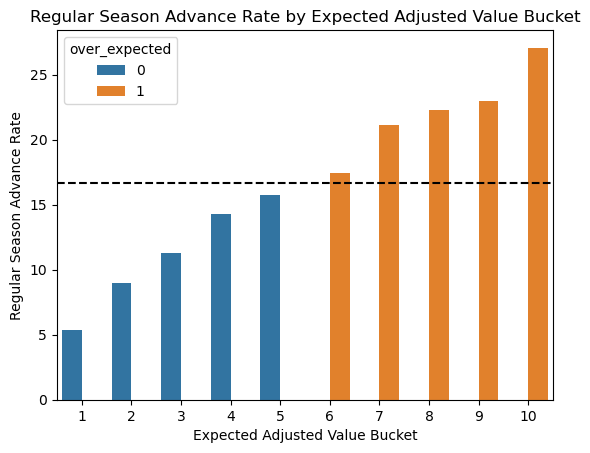

In [30]:
print('Advance rate by buckets of expected value based on model predictions from ADP:')
display((final_3days_bb_data
         .groupby(by = 'tournament_entry_id').agg(expected_value = ('expected_value', np.sum),
                                                          playoff_team = ('playoff_team','max'))
         .reset_index()
         .assign(value_percentile = lambda x: x['expected_value'].rank(pct = True),
                 value_bucket = lambda x: pd.cut(x['value_percentile'], 
                                                 bins = bins, 
                                                 labels = labels))
        )
        .groupby(by = 'value_bucket').agg(playoff_teams = ('playoff_team',np.sum),
                                          min_expected_value = ('expected_value','min'),
                                          max_expected_value = ('expected_value','max'),
                                          num_teams = ('tournament_entry_id','nunique'))
        .reset_index()
        .assign(advance_rate = lambda x: round((x['playoff_teams'] / x['num_teams']) * 100, 2),
                over_expected = lambda x: x['advance_rate'].apply(lambda y: 1 if y > ((2/12)*100) else 0),
                percent_over_expected = lambda x: round(x['advance_rate'] - ((2/12)*100), 2))
       )

sns.barplot(data = (final_3days_bb_data
         .groupby(by = 'tournament_entry_id').agg(expected_value = ('expected_value', np.sum),
                                                          playoff_team = ('playoff_team','max'))
         .reset_index()
         .assign(value_percentile = lambda x: x['expected_value'].rank(pct = True),
                 value_bucket = lambda x: pd.cut(x['value_percentile'], 
                                                 bins = bins, 
                                                 labels = labels))
        )
        .groupby(by = 'value_bucket').agg(playoff_teams = ('playoff_team',np.sum),
                                          min_expected_value = ('expected_value','min'),
                                          max_expected_value = ('expected_value','max'),
                                          num_teams = ('tournament_entry_id','nunique'))
        .reset_index()
        .assign(advance_rate = lambda x: round((x['playoff_teams'] / x['num_teams']) * 100, 2),
                over_expected = lambda x: x['advance_rate'].apply(lambda y: 1 if y > ((2/12)*100) else 0),
                percent_over_expected = lambda x: round(x['advance_rate'] - ((2/12)*100), 2)),
           x = 'value_bucket',
           y = 'advance_rate',
           hue = 'over_expected')

plt.axhline((2/12)*100,
            color = 'black',
            linestyle = '--')

plt.xlabel('Expected Adjusted Value Bucket')
plt.ylabel('Regular Season Advance Rate')
plt.title('Regular Season Advance Rate by Expected Adjusted Value Bucket')

plt.show()

#### Teams with a high expected adjusted value performed well above expectation in regular season advance rate. Teams in 90th to 100th percentile of expected adjusted value had an advance rate of 27%, 10% over expectation! 

#### Drafting to maximize expected adjusted value can help you advance past the regular season and onto the playoffs. 

## Conclusion

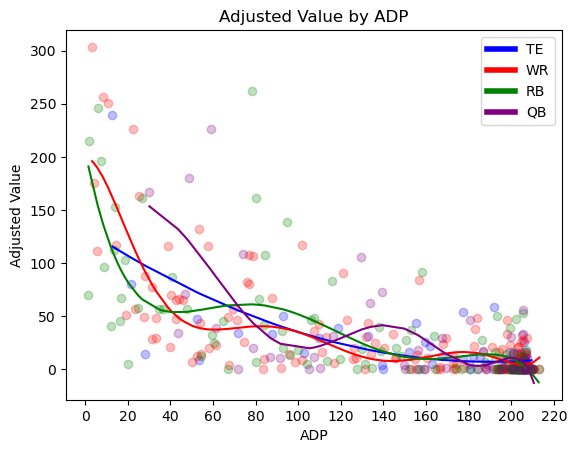

In [31]:
# Plot all positional model's predictions

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(model_data.loc[model_data['position_name'] == 'TE']['final_adp'], model_data.loc[model_data['position_name'] == 'TE']['adjusted_value'],
          c = 'blue',
          alpha = .25)
ax.plot(te_x, te_pred,
        c = 'blue')
ax.scatter(model_data.loc[model_data['position_name'] == 'WR']['final_adp'], model_data.loc[model_data['position_name'] == 'WR']['adjusted_value'],
          c = 'red',
          alpha = .25)
ax.plot(wr_x, wr_pred,
        c = 'red')
ax.scatter(model_data.loc[model_data['position_name'] == 'RB']['final_adp'], model_data.loc[model_data['position_name'] == 'RB']['adjusted_value'],
          c = 'green',
          alpha = .25)
ax.plot(rb_x, rb_pred,
         c = 'green')
ax.scatter(model_data.loc[model_data['position_name'] == 'QB']['final_adp'], model_data.loc[model_data['position_name'] == 'QB']['adjusted_value'],
          c = 'purple',
          alpha = .25)
ax.plot(qb_x, qb_pred,
         c = 'purple')

legend = [Line2D([0], [0], color= 'blue', lw=4),
          Line2D([0], [0], color='red', lw=4),
          Line2D([0], [0], color='green', lw=4),
          Line2D([0], [0], color='purple', lw=4)]

ax.legend(legend, ['TE', 'WR', 'RB', 'QB'])

plt.xticks(range(0, 221, 20))
plt.xlabel('ADP')
plt.ylabel('Adjusted Value')
plt.title('Adjusted Value by ADP')

plt.show()

#### Looking at all of the positional trendlines stacked on top of each other, we can start to identify a potential draft strategy to maximize expected adjusted value:

    1. Elite WRs early, until around pick 40 
    2. Consider taking an elite QB or TE, around picks 40 to 75
    3. Find RB value in picks 75 to 125
    4. Consider taking a backup QB, around picks 125 to 150
    5. Target expected value upside, WRs in the 170s and RBs in the 180s - 190s
    
Using the player_to_draft tool provided below, drafters can identify which players maximize their expected adjusted value. Maximizing expected adjusted value gives drafts an advantage in advancing out of the regular season and into the playoffs. 

## Player Selection Tool

### Drafters can use this "tool" to determine the player selection that would result in the the highest expected adjusted value and highest adjusted ADP value

In [32]:
# Function that finds best adjusted ADP value pick

def player_to_draft(pick, options_list):
    '''
    pick_number = Your current pick
    options_list = List of lists. Each inner list holds information about the potential selection starting 
    with position and adp.
                   i.e. [['QB',50.5], ['WR', 52], ['RB', 53.2]]
                   
    Function will output the best players to select to maximize adjusted ADP value and expected value based on ADP
    '''
    degree_dict = {'QB':9, 'WR': 7, 'RB' : 5, 'TE':2}
    
    model_dict = {'QB': qb_poly, 'WR': wr_poly, 'RB': rb_poly, 'TE': te_poly}
    
    adj_adp_value_list = []
    expected_value_list = []
    option_details = []
    
    for p in options_list:
        if p[0] not in ['QB','RB','WR','TE']:
            print('Not a valid position! Must be QB, RB, WR, or TE.')
        else:
            position = p[0]
            adp = p[1]
            poly_convertor = PolynomialFeatures(degree = degree_dict[position], include_bias= False)
            
            value_pick = model_dict[position].predict(poly_convertor.fit_transform(np.array(pick).reshape(-1,1)))[0]
    
            value_adp = model_dict[position].predict(poly_convertor.fit_transform(np.array(adp).reshape(-1,1)))[0]
    
            adj_adp_value = value_adp - value_pick
        
            adj_adp_value_list.append(adj_adp_value)
            
            expected_value_list.append(value_adp)
            
            option = position + ' (' + str(adp) + ')'
            
            option_details.append(option)
            
    print('The best selections to maximize expected value is:')
    display(pd.DataFrame().
            assign(option = option_details,
                   expected_value = expected_value_list)
            .sort_values('expected_value', ascending = False)
           )
        
    print('The best selections to maximize adjusted ADP value is:')
    display(pd.DataFrame().
            assign(option = option_details,
                   adjusted_adp_value = adj_adp_value_list)
            .sort_values('adjusted_adp_value', ascending = False)
           )      

In [33]:
# Example of using the function to help choose a player at pick 100.

player_to_draft(100, [['QB',75.6], ['RB', 94.7], ['WR',99.2], ['TE', 75.87]])

The best selections to maximize expected value is:


,option,expected_value
1,RB (94.7),55.393391
3,TE (75.87),52.120310
0,QB (75.6),50.528410
2,WR (99.2),35.481156


The best selections to maximize adjusted ADP value is:


,option,adjusted_adp_value
0,QB (75.6),31.047539
3,TE (75.87),17.017337
1,RB (94.7),3.613661
2,WR (99.2),0.497324


# I hope you enjoyed this submission, happy drafting!!!